In [ ]:
# models output : [buy, hold, sell]

In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from keras import models, layers, optimizers
from keras.losses import huber_loss
from keras.regularizers import L1L2

from collections import deque

import gc


Using TensorFlow backend.


In [2]:
class QNetwork:
    def __init__(self, input_size):
        self.model = make_models(input_size)


In [5]:
def make_models(input_size, output_size=3, n_layers=3):
    inputs = layers.Input(shape=(input_size, ))
    x = layers.Dense(16, activation='relu', kernel_regularizer = L1L2(l2= 0.001))(inputs)

    for i in range(n_layers-1):
        x = layers.Dense(16//(2**(i+1)), kernel_regularizer=L1L2(l2= 0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

    outputs = layers.Dense(output_size, activation='linear')(x)

    model = models.Model(inputs, outputs)

    model.compile(optimizer = 'adam',
                 loss = huber_loss)

    return model

In [14]:
class Memory:
    def __init__(self):
        self.buffer = deque(maxlen=memory_size)
        
    def add(self, exp):
        self.buffer.append(exp)
        
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[i] for i in idx]
    
    def reset(self):
        self.buffer = deque(maxlen=memory_size)
        
    def __len__(self):
        return len(self.buffer)
    
    

In [7]:
data = pd.read_csv('./data/stock.csv', thousands=',')
d = data.drop(['date', 'close', 'high', 'low'], axis=1)
d.columns

moving = pd.Series()
for cat in d.columns:
    for i in (5, 10, 30, 60):
        moving = pd.concat([moving, d[cat].rolling(i).mean()], axis=1)
        
moving.columns = ['0', 'moving_p5','moving_p10','moving_p30','moving_p60',
                  'moving_vol5','moving_vol10','moving_vol30','moving_vol60',
                  'moving_per5','moving_per10','moving_per30','moving_per60',
                  'moving_pbr5','moving_pbr10','moving_pbr30','moving_pbr60']

moving = moving.drop('0', axis=1)
moving = pd.concat([moving, data.high, data.low], axis=1)

X = moving[61:]
y = data.open[61:]

X = (X - np.min(X))/(np.max(X) - np.min(X))
y = (y - np.min(y))/(np.max(y) - np.min(y))

state = X.values.copy()
p = y.values.copy()
p += 1e-5

In [22]:
# target set control needed
class Agent:
    def __init__(self, balance, state):
        self.fs = [balance, 0] # [cash, n_stock]
        self.balance = balance
        self.state = state
        self.main = make_models(18)
        self.learner = make_models(18)
        
        self.hist = []
        
        
    def train(self, n_steps):
        for n in range(n_steps):
            memory.reset()
            self.fs = [1, 0]
            self.balance = 1
            step = 0
            steps = len(self.state)
            for i in range(0, steps-2):
                step += 1
                eps = 0.01 + (EPS - 0.01) * np.exp(-DECAY * step)

                self.learner.set_weights(self.main.get_weights())

                # action 
                if eps > np.random.rand():
                    action = np.random.choice([0, 1, 2])
                else:
                    action = np.argmax(self.main.predict(state[i:i+1]))

                # current stock price
                price = p[i]
                # update fs
                self.fs = self.update_fs(self.fs, action, price)
                # update balance and make reward
                new_balance = self.update_balance(self.fs, price)

                reward = ((new_balance / self.balance) - 1)
#                 print(reward)

                self.balance = new_balance

                # memorize
#                 if step > WARMUP:
                memory.add((state[i:i+1], action, reward, state[i+1:i+2]))

            # learner update
            print('take')
            for _ in range(TRAIN_STEP):
                inputs = np.zeros((BATCH_SIZE, 18))
                targets = np.zeros((BATCH_SIZE, 3))

                minibatch = memory.sample(BATCH_SIZE)

                for j, (s, a, r, ss) in enumerate(minibatch):
                    inputs[j] = s
                    if not (ss == np.zeros(s.shape)).all(axis=1):
                        target = r + GAMMA * np.argmax(self.learner.predict(ss))
                    else:
                        target = r

                    targets[j] = self.main.predict(s)
                    targets[j][a] += target*0.01

                self.main.fit(inputs, targets, epochs=1, verbose=0)
                
                self.hist.append(self.balance)
                hist = self.simulation()
                hist = np.array(hist) - BALANCE
                plt.axhline(y=0, color='r', linestyle='-')
                plt.plot(hist)
                plt.show()
                print((n+1), 'steps','mean gain:', np.mean(hist))

            # as episode end

                    
            
    def update_fs(self, fs, action, price):
        if action == 0: # buy
            n = fs[0] // price
            b = fs[0] % price
            new_n = fs[1]+ n
            return [b, new_n]
        
        elif action == 1: # hold
            return fs
        
        else: # sell
            b = fs[1] * price
            new_b = fs[0]+b
            return [new_b, 0]
        
    
    def update_balance(self, fs, price):
        b = fs[0] + fs[1] * price
#         print(b, self.fs)
        return b
        
    def simulation(self):
        fs = [BALANCE, 0]
        balance = BALANCE
        hist = []
        sales = [0, 0, 0]
        for i in range(len(state)-1):
            a = np.argmax(self.main.predict(self.state[i:i+1]))
            price = p[i]
            fs = self.update_fs(fs, a, price)
            balance = self.update_balance(fs, price)
            hist.append(balance)
            sales[a] += 1
#             print(fs)
        print(sales)
        return hist
    
    def clipping(self, r):
        if r > 0: return 1
        elif r < 0 : return -1
        else: return 0
        
#     def make_reward(self, action, reward):
#         if reward > 0:
            

In [23]:
GAMMA = 0.99
WARMUP = 20
N_EPISODES = 2
EPS = 0.3
DECAY = 0.001

memory_size = 1000
BATCH_SIZE = 128
TRAIN_STEP = 200

BALANCE = 10

memory = Memory()
a = Agent(1, state)
gc.collect()

0

take
[0, 558, 2681]


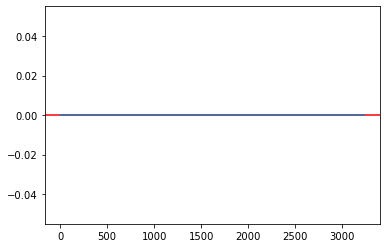

1 steps mean gain: 0.0
[3, 1010, 2226]


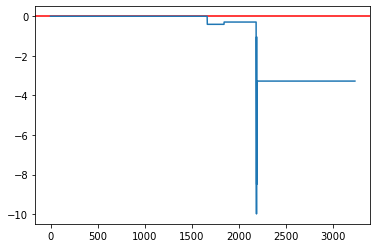

1 steps mean gain: -1.122344159462177
[245, 1432, 1562]


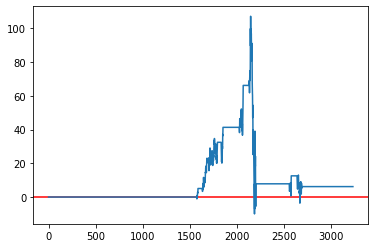

1 steps mean gain: 9.10629372572696
[479, 1520, 1240]


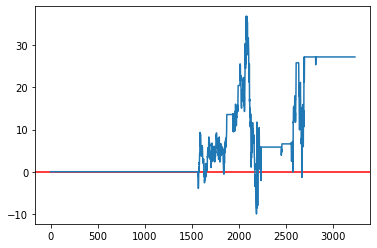

1 steps mean gain: 7.650537099561224
[799, 1496, 944]


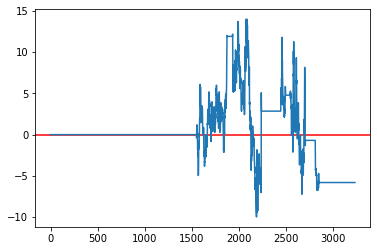

1 steps mean gain: 0.2809845386124043
[1040, 1371, 828]


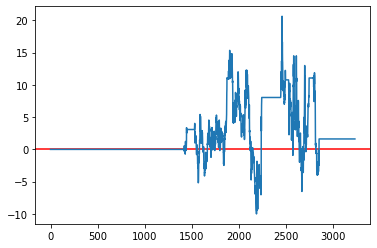

1 steps mean gain: 2.082615007825261
[1156, 1350, 733]


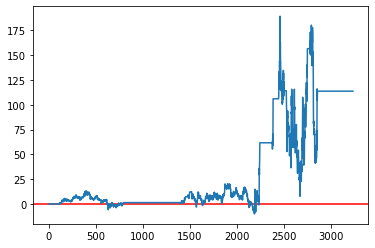

1 steps mean gain: 32.48669914417775
[1274, 1295, 670]


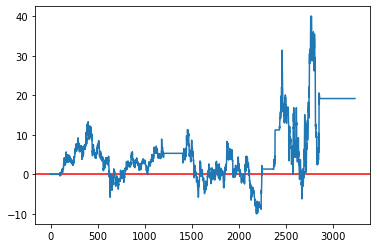

1 steps mean gain: 5.779918813882462
[1391, 1251, 597]


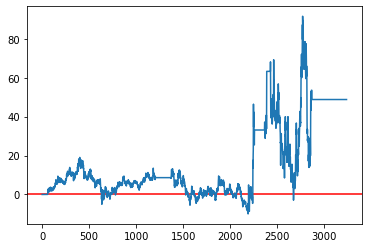

1 steps mean gain: 15.766112050758267
[1517, 1154, 568]


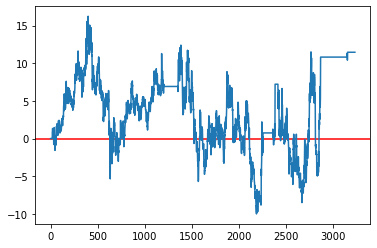

1 steps mean gain: 3.7100899998051524
[1696, 997, 546]


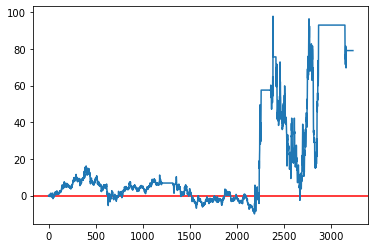

1 steps mean gain: 20.225637006180524
[1827, 903, 509]


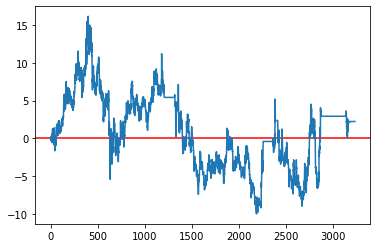

1 steps mean gain: 0.933736101366333
[2011, 815, 413]


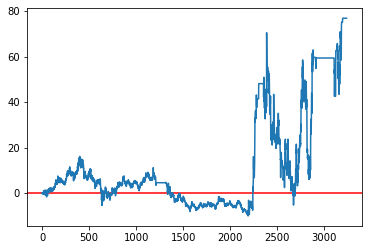

1 steps mean gain: 12.754443738604907
[2244, 654, 341]


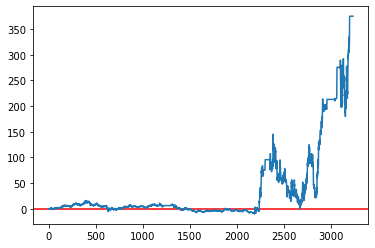

1 steps mean gain: 39.61671270515775
[2480, 501, 258]


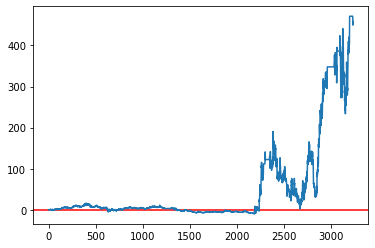

1 steps mean gain: 54.9833429218513
[2673, 375, 191]


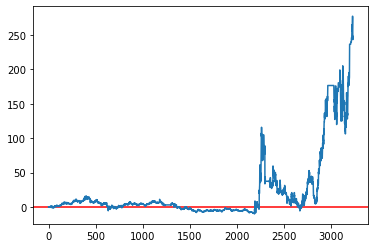

1 steps mean gain: 23.67148871164071
[2906, 192, 141]


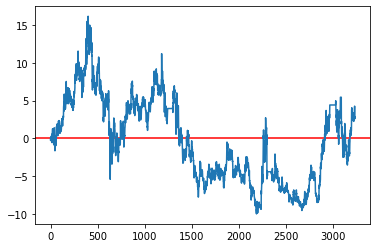

1 steps mean gain: -0.24743639112649618
[3007, 147, 85]


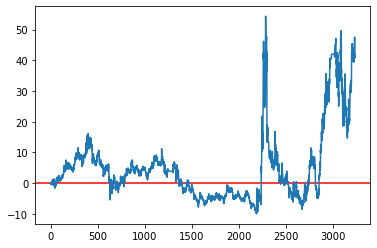

1 steps mean gain: 5.273252758786971
[3057, 139, 43]


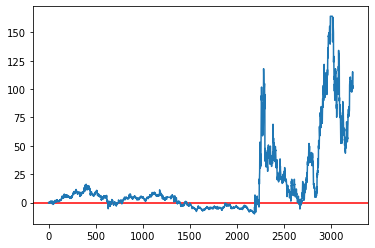

1 steps mean gain: 17.236610014437428
[3118, 104, 17]


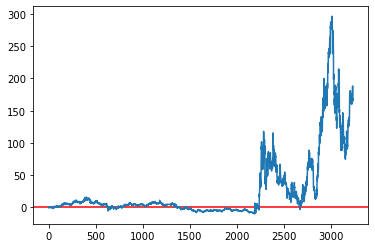

1 steps mean gain: 27.74778961118802
[3165, 66, 8]


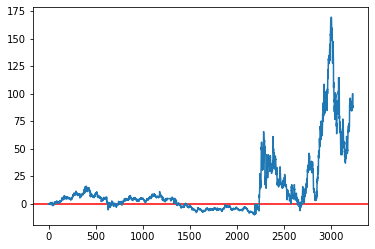

1 steps mean gain: 14.600542467593323
[3186, 51, 2]


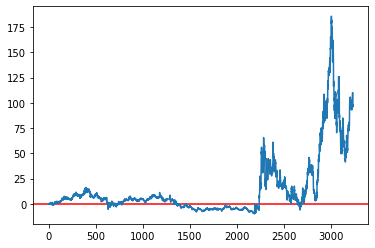

1 steps mean gain: 15.076436259135011
[3210, 29, 0]


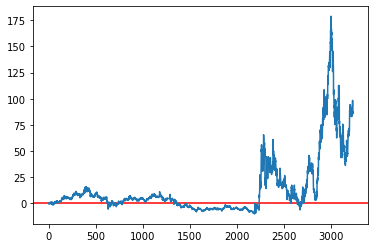

1 steps mean gain: 14.379356032058562
[3212, 27, 0]


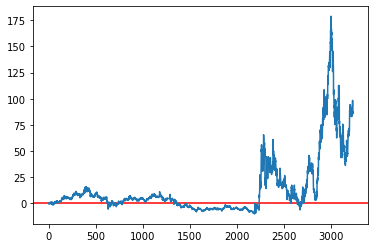

1 steps mean gain: 14.379356032058562
[3221, 18, 0]


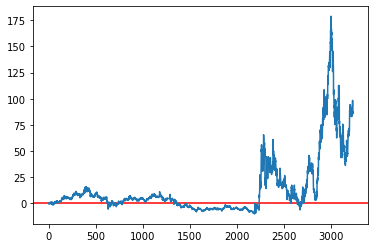

1 steps mean gain: 14.379356032058562
[3222, 17, 0]


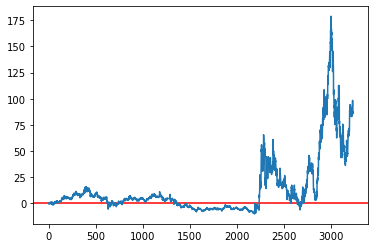

1 steps mean gain: 14.379356032058562
[3226, 13, 0]


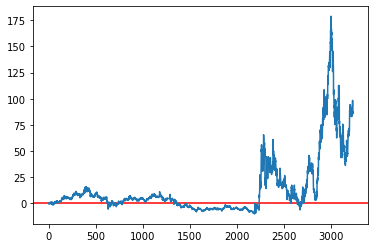

1 steps mean gain: 14.379356032058562
[3231, 8, 0]


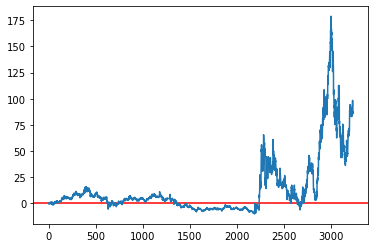

1 steps mean gain: 14.379356032058562
[3236, 3, 0]


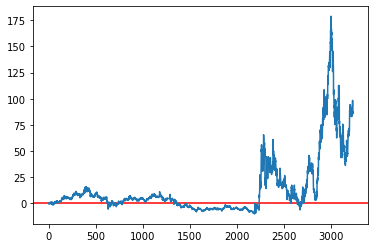

1 steps mean gain: 14.379356032058562
[3239, 0, 0]


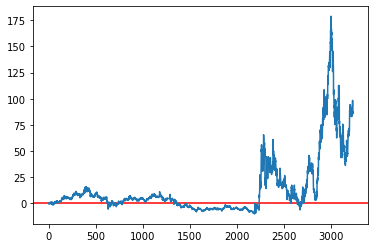

1 steps mean gain: 14.379356032058562
[3238, 1, 0]


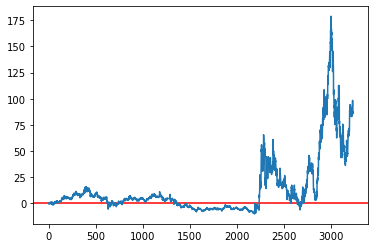

1 steps mean gain: 14.379356032058562
[3237, 2, 0]


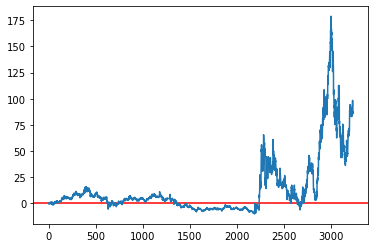

1 steps mean gain: 14.379356032058562
[3235, 4, 0]


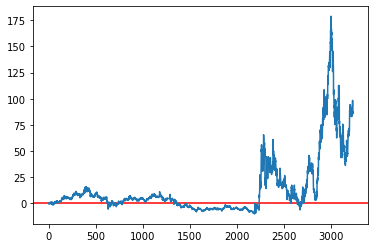

1 steps mean gain: 14.379356032058562
[3231, 8, 0]


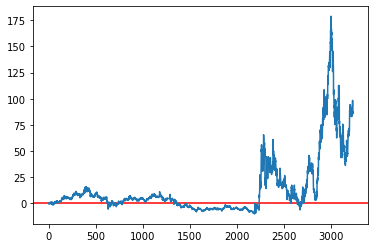

1 steps mean gain: 14.379356032058562


KeyboardInterrupt: 

In [24]:
%%time
a.train(10)

In [21]:
gc.collect()

65710

In [12]:
a.main.predict(state)

array([[-23.124722, -37.03664 ,  19.51838 ],
       [-23.245745, -37.300358,  19.788582],
       [-23.365194, -37.456154,  19.788784],
       ...,
       [ -8.738687, -15.301094,  11.914242],
       [ -8.617061, -15.088175,  11.775595],
       [ -8.360707, -14.569633,  11.305433]], dtype=float32)

In [ ]:
plt.plot(p)

In [ ]:
2 % 3